<div class="alert alert-info">
Import the libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, make_scorer
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
#from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, hp - работает надо добить
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor
#from lofo import LOFOImportance, Dataset, plot_importance

import lightgbm as lgb
import xgboost as xgb
import catboost as ctb

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13163246302818640081
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8854196736
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12509240489559913451
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:09:00.0, compute capability: 8.6"
]


<div class="alert alert-info">
Let's import some functions. 

In [3]:
def data_info(table):
    table.info(memory_usage='deep')
    display(table.head(7))

def unique_checks(table):
    for i in range(len(df.columns)):
        display(pd.DataFrame(df[df.columns[i]].value_counts()))

def unique_check(table,column):
    display(table[column].value_counts())

def corr_info(table):
    display(table.corr())
    plt.figure(figsize=(18,18))
    heatmap0 = sns.heatmap(table.corr(), 
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': 1, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})
    plt.show()

def calc_vif(features):
    vif = pd.DataFrame()
    vif["variables"] = features.columns
    vif["VIF"] = [round(variance_inflation_factor(features.values, i),4) for i in range(features.shape[1])]
    vif_ord = vif.sort_values(by='VIF',ascending=False).set_index('variables')
    return(vif_ord)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def make_date(value):
    if value == "No":
        return '2020-02-01'
    else:
        return value

def check_no(value):
    if value == "No":
        return 0
    else:
        return 1

def check_make(value):
    if value == "No":
        return 0
    else:
        return 1

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

def roc_auc_plot(curve_train,curve_valid): 
    plt.figure()
    plt.plot(curve_train[0], curve_train[1])
    plt.plot(curve_valid[0], curve_valid[1])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

def plot_feature_importance(importance,names,model_type): 
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(15,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

def gridsearch(estimator,param_grid,xtrain,ytrain,xvalid,yvalid,cv,scoring):
    gridsearch = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring=scoring, cv = cv, n_jobs = -1, verbose = 2)
    gridsearch.fit(xtrain,ytrain)
    best = gridsearch.best_estimator_

    predtrain = gridsearch.predict(xtrain)
    probabilities_train = gridsearch.predict_proba(xtrain)[:, 1]
    rocauc_train_proba = roc_auc_score(ytrain,probabilities_train)
    accuracy_train = accuracy_score(predtrain,ytrain)
    conf_train = confusion_matrix(predtrain,ytrain)
    TP_train = conf_train[1,1]
    TN_train = conf_train[0,0]
    FP_train = conf_train[0,1]
    FN_train = conf_train[1,0]
    correct_train = format(TP_train+TN_train,'.0f')
    inncorrect_train = format(FP_train+FN_train,'.0f')
    
    predvalid = gridsearch.predict(xvalid)
    probabilities_valid = gridsearch.predict_proba(xvalid)[:, 1]
    rocauc_valid_proba = roc_auc_score(yvalid,probabilities_valid)
    accuracy_valid = accuracy_score(predvalid,yvalid)
    conf_valid = confusion_matrix(predvalid,yvalid)
    TP_valid = conf_valid[1,1]
    TN_valid = conf_valid[0,0]
    FP_valid = conf_valid[0,1]
    FN_valid = conf_valid[1,0]
    correct_valid = format(TP_valid+TN_valid,'.0f')
    inncorrect_valid = format(FP_valid+FN_valid,'.0f')

    stats = {'stats': ['accuracy','roc_auc_proba','correct_guesses','incorrect_guesses'],
             'values_test': [accuracy_train,rocauc_train_proba,correct_train,inncorrect_train],
             'values_valid': [accuracy_valid,rocauc_valid_proba,correct_valid,inncorrect_valid],
            }

    final_stats = pd.DataFrame(stats).set_index('stats')

    fprtrain, tprtrain, thresholdstrain = roc_curve(ytrain, probabilities_train)
    fprvalid, tprvalid, thresholdsvalid = roc_curve(yvalid, probabilities_valid)
    
    curve_train = [fprtrain, tprtrain]
    curve_valid = [fprvalid, tprvalid]

    return final_stats, curve_train, curve_valid, best

def neural_net(xtrain,ytrain,xvalid,yvalid,epochs):
    with tf.device("/GPU:0"):
        nn_model = Sequential()
        nn_model.add(Dense(units=15, input_dim=xtrain.shape[1],activation='sigmoid',activity_regularizer=keras.regularizers.l1(0.01)))
        nn_model.add(Dense(units=10, activation='sigmoid',activity_regularizer=keras.regularizers.l2(0.01)))
        nn_model.add(Dense(units=3, activation='sigmoid'))
        nn_model.add(Dense(units=1, activation='sigmoid'))

        nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='auc')])
        history = nn_model.fit(xtrain,ytrain, epochs=epochs, verbose=0,validation_data=(xvalid,yvalid))

        predtrain = nn_model.predict(xtrain)
        probabilities_train = nn_model.predict_proba(xtrain)
        rocauc_train = roc_auc_score(ytrain,probabilities_train)
    
        predvalid = nn_model.predict(xvalid)
        probabilities_valid = nn_model.predict_proba(xvalid)
        rocauc_valid = roc_auc_score(yvalid,probabilities_valid)

        return history, rocauc_train, rocauc_valid

In [4]:
contract = pd.read_csv('C:/Users/OB/Desktop/projects_to_do/project_9/contract.csv',index_col = 'customerID')
internet = pd.read_csv('C:/Users/OB/Desktop/projects_to_do/project_9/internet.csv',index_col = 'customerID')
personal = pd.read_csv('C:/Users/OB/Desktop/projects_to_do/project_9/personal.csv',index_col = 'customerID')
phone = pd.read_csv('C:/Users/OB/Desktop/projects_to_do/project_9/phone.csv',index_col = 'customerID')
df = pd.concat([contract,internet,personal,phone],axis=1)

In [5]:
#unique_checks(df)

<div class="alert alert-info">
For phone, if there is no connections therefore client does not use phone. And also let's generate feature that counts days.

In [6]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%dT%H:%M:%S')
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')
df['InternetService'] = df['InternetService'].replace(np.NaN,"undef")
df['OnlineSecurity'] = df['OnlineSecurity'].replace(np.NaN,"No")
df['OnlineBackup'] = df['OnlineSecurity'].replace(np.NaN,"No")
df['DeviceProtection'] = df['DeviceProtection'].replace(np.NaN,"No")
df['TechSupport'] = df['TechSupport'].replace(np.NaN,"No")
df['StreamingTV'] = df['StreamingTV'].replace(np.NaN,"No")
df['MultipleLines'] = df['MultipleLines'].replace(np.NaN,"No")
df['StreamingMovies'] = df['StreamingMovies'].replace(np.NaN,"No")
df['FinalDate'] = df['EndDate'].apply(make_date)
df['FinalDate'] = pd.to_datetime(df['FinalDate'], format='%Y-%m-%dT%H:%M:%S')
df['Days'] = abs(df['FinalDate'] - df['BeginDate']).dt.days
df['EndDate_target'] = df['EndDate'].apply(check_no)
df = df.dropna()
data_info(df)
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   object        
 2   Type              7032 non-null   object        
 3   PaperlessBilling  7032 non-null   object        
 4   PaymentMethod     7032 non-null   object        
 5   MonthlyCharges    7032 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   InternetService   7032 non-null   object        
 8   OnlineSecurity    7032 non-null   object        
 9   OnlineBackup      7032 non-null   object        
 10  DeviceProtection  7032 non-null   object        
 11  TechSupport       7032 non-null   object        
 12  StreamingTV       7032 non-null   object        
 13  StreamingMovies   7032 non-null   object        
 14  gender        

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,FinalDate,Days,EndDate_target
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,No,...,No,No,Female,0,Yes,No,No,2020-02-01,31,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,Yes,...,No,No,Male,0,No,No,No,2020-02-01,1036,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,...,No,No,Male,0,No,No,No,2019-12-01,61,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,Yes,...,No,No,Male,0,No,No,No,2020-02-01,1371,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,...,No,No,Female,0,No,No,No,2019-11-01,61,1
9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,No,...,Yes,Yes,Female,0,No,No,Yes,2019-11-01,245,1
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,No,...,Yes,No,Male,0,No,Yes,Yes,2020-02-01,671,0


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,FinalDate,Days,EndDate_target
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,No,...,No,No,Female,0,Yes,No,No,2020-02-01,31,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,Yes,...,No,No,Male,0,No,No,No,2020-02-01,1036,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,...,No,No,Male,0,No,No,No,2019-12-01,61,1


In [7]:
df_before_ord = df.drop('EndDate', axis = 1)
encoder = OrdinalEncoder()
object_columns = df_before_ord.select_dtypes('object').columns
data_part1 = df_before_ord.drop(object_columns,axis = 1).reset_index()
data_part2 = pd.DataFrame(encoder.fit_transform(df_before_ord[object_columns]),columns=object_columns)
data = pd.concat([data_part1,data_part2], axis = 1)
data = data.set_index('customerID')
#data = data.set_index('index') # ВЗЯЛ НА СЕБЯ СМЕЛОСТЬ СКОРРЕКТИРОВАТЬ, ЧТОБЫ НЕ ПЕРЕКИДВАТЬ ЗРЯ И НЕ ТЕРЯТЬ ВРЕМЯ
reduce_mem_usage(data)
data_info(data)

Mem. usage decreased to  0.40 Mb (65.9% reduction)
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   MonthlyCharges    7032 non-null   float16       
 2   TotalCharges      7032 non-null   float16       
 3   SeniorCitizen     7032 non-null   int8          
 4   FinalDate         7032 non-null   datetime64[ns]
 5   Days              7032 non-null   int16         
 6   EndDate_target    7032 non-null   int8          
 7   Type              7032 non-null   float16       
 8   PaperlessBilling  7032 non-null   float16       
 9   PaymentMethod     7032 non-null   float16       
 10  InternetService   7032 non-null   float16       
 11  OnlineSecurity    7032 non-null   float16       
 12  OnlineBackup      7032 non-null   float16       
 13  DeviceProtection 

,BeginDate,MonthlyCharges,TotalCharges,SeniorCitizen,FinalDate,Days,EndDate_target,Type,PaperlessBilling,PaymentMethod,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,29.84375,29.84375,0,2020-02-01,31,0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5575-GNVDE,2017-04-01,56.93750,1890.00000,0,2020-02-01,1036,0,1.0,0.0,3.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3668-QPYBK,2019-10-01,53.84375,108.12500,0,2019-12-01,61,1,0.0,1.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7795-CFOCW,2016-05-01,42.31250,1841.00000,0,2020-02-01,1371,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9237-HQITU,2019-09-01,70.68750,151.62500,0,2019-11-01,61,1,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9305-CDSKC,2019-03-01,99.62500,820.50000,0,2019-11-01,245,1,0.0,1.0,2.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1452-KIOVK,2018-04-01,89.12500,1949.00000,0,2020-02-01,671,0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


<div class="alert alert-info">
Let's look at correlations and calculate VIF.
'EndDate_target','BeginDate','FinalDate','OnlineBackup','MonthlyCharges','TotalCharges' have some strong coorelations. Delete them and VIF become much better. Even with storng detachment of Days.

,VIF,VIF,VIF
variables,,,
MonthlyCharges,15.3214,NaN,NaN
Days,14.4243,14.2764,6.9753
TotalCharges,13.8813,12.8926,NaN
Type,4.1039,3.8729,3.7114
InternetService,3.2161,2.9005,2.8911
StreamingMovies,2.9879,2.7296,2.5614
PaymentMethod,2.9664,2.6021,2.5117
StreamingTV,2.9657,2.7061,2.5214
PaperlessBilling,2.8770,2.4854,2.4839


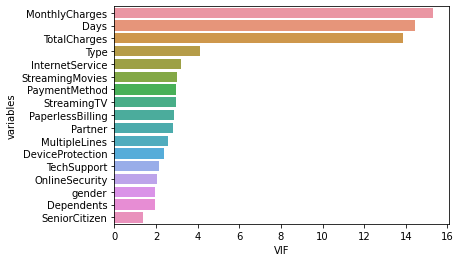

In [8]:
test_df1 = data.drop(['EndDate_target','BeginDate','FinalDate','OnlineBackup'],axis=1)
test_df2 = data.drop(['EndDate_target','BeginDate','FinalDate','OnlineBackup','MonthlyCharges'],axis=1)
test_df3 = data.drop(['EndDate_target','BeginDate','FinalDate','OnlineBackup','MonthlyCharges','TotalCharges'],axis=1)
test1 = calc_vif(test_df1)
test2 = calc_vif(test_df2)
test3 = calc_vif(test_df3)
vif = pd.concat([test1,test2,test3],axis=1)
sns.barplot(x=test1['VIF'], y=test1.index)
display(vif)

,SeniorCitizen,Days,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,Partner,Dependents,MultipleLines
SeniorCitizen,1.000000,0.015630,-0.141820,0.156258,-0.038158,-0.032160,-0.038576,0.059514,-0.060577,0.105445,0.119842,-0.001819,0.016957,-0.210550,0.142996
Days,0.015630,1.000000,0.676787,0.004729,-0.370053,-0.029809,0.328299,0.361469,0.325307,0.280165,0.285298,0.005290,0.381924,0.163442,0.332292
Type,-0.141820,0.676787,1.000000,-0.175475,-0.229636,0.099579,0.245660,0.219648,0.293967,0.104178,0.109136,0.000095,0.294094,0.240556,0.107529
PaperlessBilling,0.156258,0.004729,-0.175475,1.000000,-0.061348,-0.138166,-0.004051,0.104079,0.037536,0.224241,0.211583,-0.011902,-0.013957,-0.110131,0.163746
PaymentMethod,-0.038158,-0.370053,-0.229636,-0.061348,1.000000,0.084504,-0.149112,-0.180931,-0.156296,-0.148563,-0.154854,0.016942,-0.156232,-0.041989,-0.171240
InternetService,-0.032160,-0.029809,0.099579,-0.138166,0.084504,1.000000,-0.392174,-0.305757,-0.388535,-0.241330,-0.250144,-0.002236,0.000513,0.044030,0.011346
OnlineSecurity,-0.038576,0.328299,0.245660,-0.004051,-0.149112,-0.392174,1.000000,0.274875,0.354458,0.175514,0.187426,-0.016328,0.143346,0.080786,0.098592
DeviceProtection,0.059514,0.361469,0.219648,0.104079,-0.180931,-0.305757,0.274875,1.000000,0.332850,0.389924,0.402309,-0.000807,0.153556,0.013900,0.201733
TechSupport,-0.060577,0.325307,0.293967,0.037536,-0.156296,-0.388535,0.354458,0.332850,1.000000,0.277549,0.280155,-0.008507,0.120206,0.063053,0.100421
StreamingTV,0.105445,0.280165,0.104178,0.224241,-0.148563,-0.241330,0.175514,0.389924,0.277549,1.000000,0.533380,-0.007124,0.124483,-0.016499,0.257804


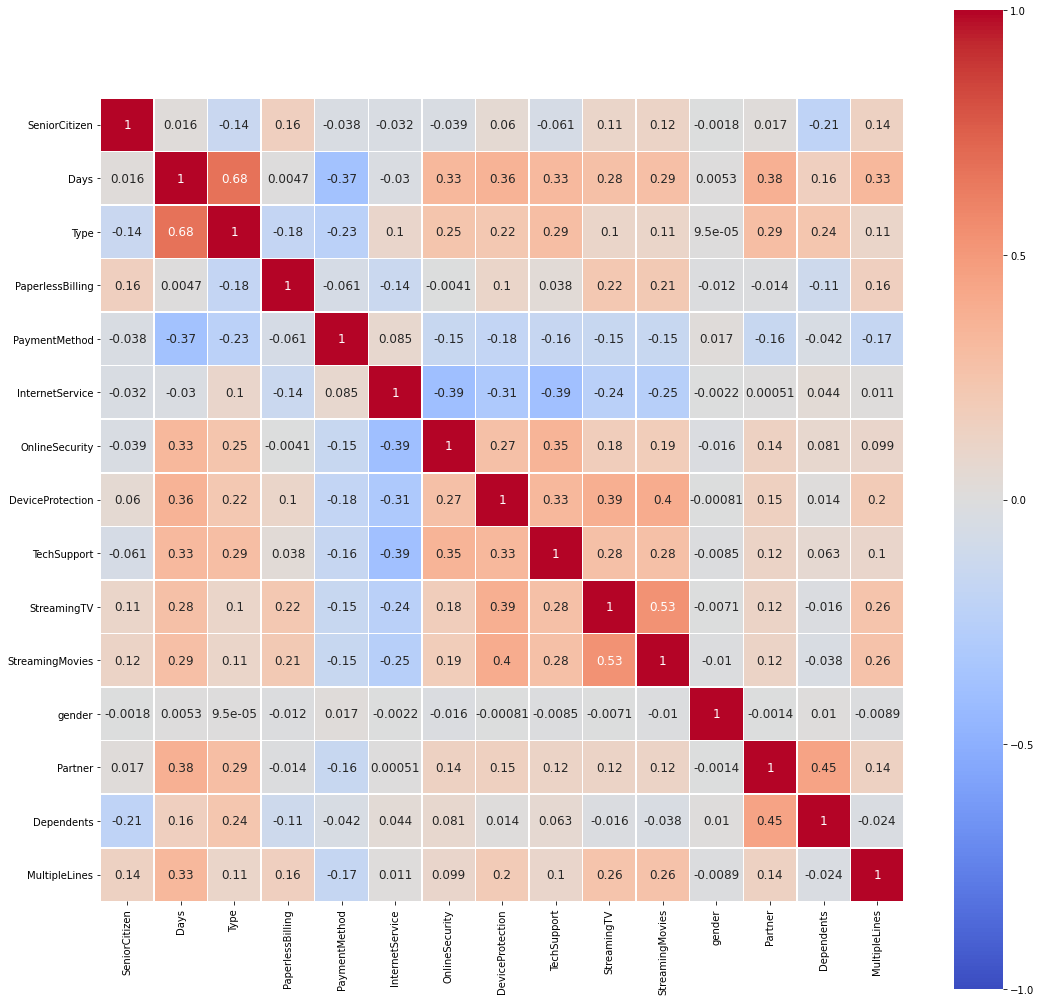

In [9]:
corr_info(test_df3)

In [10]:
target = data['EndDate_target']
features_ns = data.drop(['TotalCharges','EndDate_target','BeginDate','FinalDate'],axis=1)
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features_ns),columns = features_ns.columns,index=features_ns.index)
train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size=0.25, random_state=21435,stratify=target)
scorer = make_scorer(roc_auc_score)

In [11]:
train_features_down, train_target_down = downsample(train_features, train_target, 0.5)
data_info(train_features_down)

<class 'pandas.core.frame.DataFrame'>
Index: 3338 entries, 8630-FJLIB to 7813-TKCVO
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MonthlyCharges    3338 non-null   float32
 1   SeniorCitizen     3338 non-null   float32
 2   Days              3338 non-null   float32
 3   Type              3338 non-null   float32
 4   PaperlessBilling  3338 non-null   float32
 5   PaymentMethod     3338 non-null   float32
 6   InternetService   3338 non-null   float32
 7   OnlineSecurity    3338 non-null   float32
 8   OnlineBackup      3338 non-null   float32
 9   DeviceProtection  3338 non-null   float32
 10  TechSupport       3338 non-null   float32
 11  StreamingTV       3338 non-null   float32
 12  StreamingMovies   3338 non-null   float32
 13  gender            3338 non-null   float32
 14  Partner           3338 non-null   float32
 15  Dependents        3338 non-null   float32
 16  MultipleLines     3338 non-null 

,MonthlyCharges,SeniorCitizen,Days,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,
8630-FJLIB,0.166673,-0.440327,-0.586987,-0.826735,0.828939,0.399805,0.172835,-0.633746,-0.633746,-0.723918,-0.639260,-0.790186,-0.796849,-1.009430,-0.965608,-0.652305,-0.854336
8183-ONMXC,0.530241,-0.440327,-1.240179,-0.826735,-1.206361,0.399805,0.172835,-0.633746,-0.633746,-0.723918,-0.639260,-0.790186,1.254943,-1.009430,-0.965608,-0.652305,-0.854336
7562-GSUHK,0.943669,-0.440327,-0.668636,-0.826735,0.828939,-0.537026,0.172835,-0.633746,-0.633746,1.381372,-0.639260,-0.790186,1.254943,-1.009430,-0.965608,-0.652305,-0.854336
2634-HCZGT,-0.157422,2.271039,0.838524,0.373926,0.828939,0.399805,-1.183614,1.577918,1.577918,-0.723918,1.564308,-0.790186,-0.796849,0.990658,1.035617,-0.652305,1.170500
8746-OQQRW,-1.314606,-0.440327,-1.157192,-0.826735,-1.206361,1.336636,1.529285,-0.633746,-0.633746,-0.723918,-0.639260,-0.790186,-0.796849,0.990658,-0.965608,-0.652305,1.170500
9728-FTTVZ,0.145898,-0.440327,-1.281673,-0.826735,0.828939,0.399805,0.172835,-0.633746,-0.633746,-0.723918,-0.639260,-0.790186,-0.796849,-1.009430,-0.965608,-0.652305,-0.854336
5057-LCOUI,-0.466974,-0.440327,0.266981,-0.826735,0.828939,0.399805,-1.183614,-0.633746,-0.633746,1.381372,-0.639260,1.265525,1.254943,-1.009430,-0.965608,-0.652305,-0.854336


Let's try main ML techniques and Neural Net.

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,values_test,values_valid
stats,,
accuracy,0.740994,0.738339
roc_auc_proba,0.840971,0.832476
correct_guesses,3908,1298
incorrect_guesses,1366,460


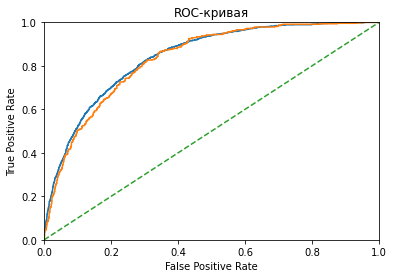

In [12]:
logistic = LogisticRegression()
param_logist = {
    'class_weight':['balanced'],
    'solver':['lbfgs', 'liblinear']
}
log_data, roc_log_train, roc_log_valid, log_best = gridsearch(logistic,param_logist,train_features, train_target, valid_features, valid_target, 5, scorer)
display(log_data)
roc_auc_plot(roc_log_train,roc_log_valid)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,values_test,values_valid
stats,,
accuracy,0.772848,0.754835
roc_auc_proba,0.880922,0.850592
correct_guesses,4076,1327
incorrect_guesses,1198,431


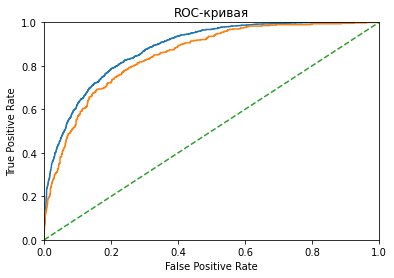

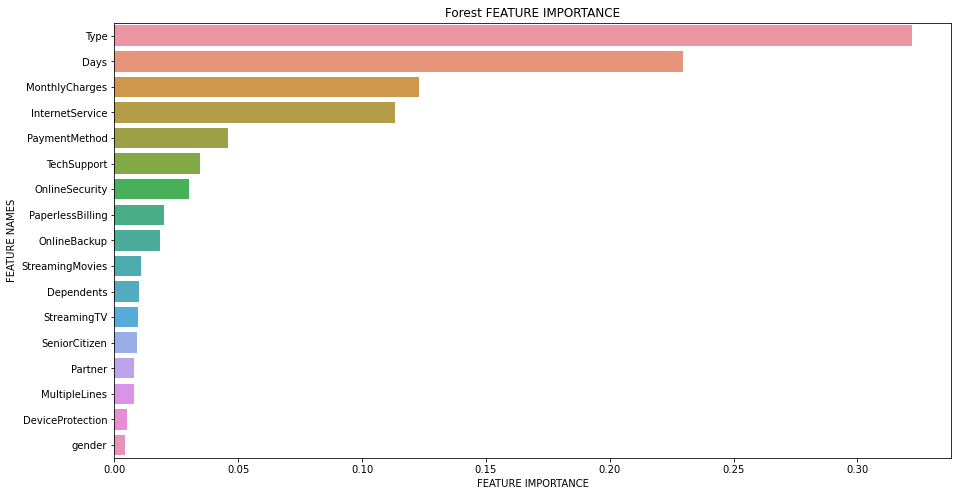

In [13]:
forest = RandomForestClassifier(random_state=13425)
param_forest = {
    'n_estimators': range(1,151,20),
    'max_depth': range(1,31,5),
    'criterion' : ["gini", "entropy"],
    'class_weight': ["balanced"],
    'min_samples_leaf' : range(1,3,1),
    'min_samples_split' : range(2,4,1)
}

forest_data, roc_for_train, roc_for_valid, for_best = gridsearch(forest,param_forest,train_features, train_target, valid_features, valid_target, 5, scorer)
display(forest_data)
roc_auc_plot(roc_for_train,roc_for_valid)
plot_feature_importance(for_best.feature_importances_,train_features.columns,'Forest ')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


,values_test,values_valid
stats,,
accuracy,0.918847,0.852673
roc_auc_proba,0.97674,0.903362
correct_guesses,4846,1499
incorrect_guesses,428,259


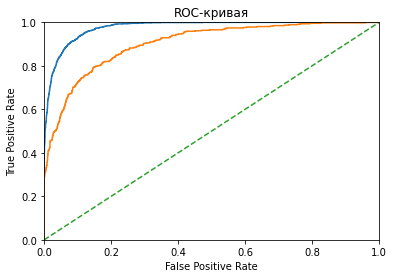

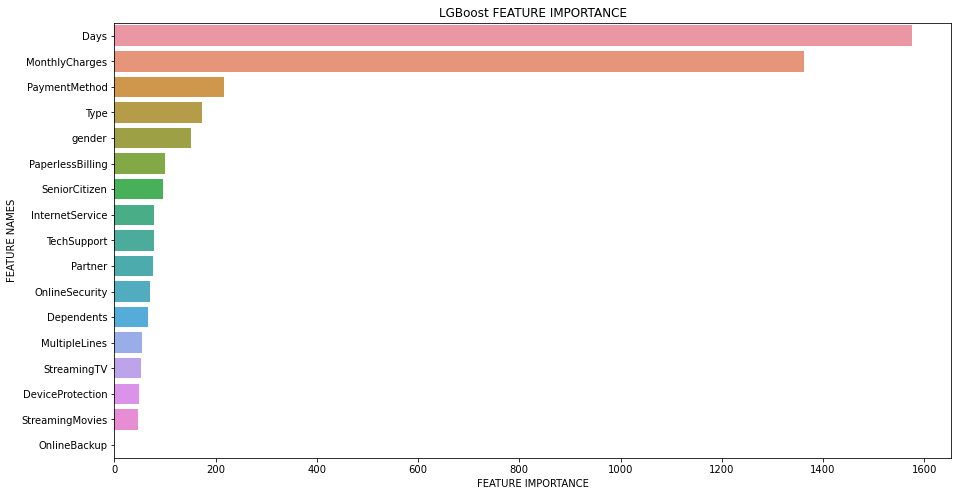

In [14]:
lgb = LGBMClassifier(random_state=13425)
param_lgb = {'learning_rate' : [0.01,0.05,0.1],
                  "num_leaves": range(300,501,100),
                  'n_estimators': range(1,151,20),
                  'max_depth': range(1,21,5),
                 }

lgb_data, roc_lgb_train, roc_lgb_valid, lgb_best = gridsearch(lgb,param_lgb,train_features, train_target, valid_features, valid_target, 5, scorer)
display(lgb_data)
roc_auc_plot(roc_lgb_train,roc_lgb_valid)
plot_feature_importance(lgb_best.feature_importances_,train_features.columns,'LGBoost ')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.6069353	total: 140ms	remaining: 35s
1:	learn: 0.5339315	total: 142ms	remaining: 17.6s
2:	learn: 0.4975626	total: 143ms	remaining: 11.8s
3:	learn: 0.4773668	total: 145ms	remaining: 8.9s
4:	learn: 0.4545756	total: 146ms	remaining: 7.17s
5:	learn: 0.4386028	total: 148ms	remaining: 6.01s
6:	learn: 0.4222736	total: 149ms	remaining: 5.18s
7:	learn: 0.4172403	total: 151ms	remaining: 4.56s
8:	learn: 0.4118527	total: 152ms	remaining: 4.08s
9:	learn: 0.4062896	total: 154ms	remaining: 3.69s
10:	learn: 0.4028363	total: 155ms	remaining: 3.38s
11:	learn: 0.3998630	total: 157ms	remaining: 3.11s
12:	learn: 0.3940202	total: 159ms	remaining: 2.89s
13:	learn: 0.3914540	total: 160ms	remaining: 2.7s
14:	learn: 0.3871443	total: 162ms	remaining: 2.53s
15:	learn: 0.3822771	total: 163ms	remaining: 2.38s
16:	learn: 0.3807023	total: 164ms	remaining: 2.25s
17:	learn: 0.3792143	total: 166ms	remaining: 2.14s
18:	learn: 0.3761854	total: 168ms	

,values_test,values_valid
stats,,
accuracy,0.940273,0.884528
roc_auc_proba,0.980454,0.93106
correct_guesses,4959,1555
incorrect_guesses,315,203


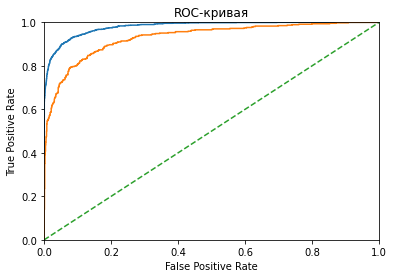

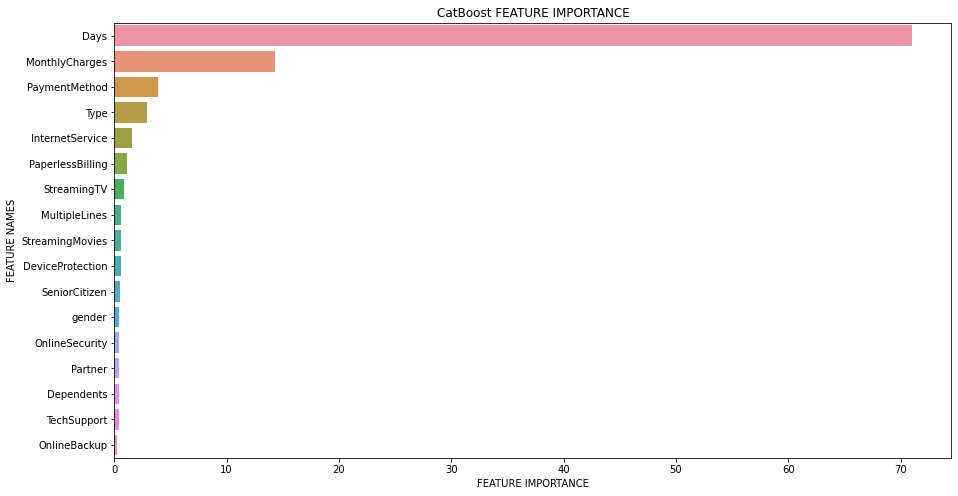

In [15]:
cb = CatBoostClassifier()
param_cb = {'depth': [4, 7, 10],
            'learning_rate' : [0.03, 0.1, 0.15],
            'iterations': [250],
            'l2_leaf_reg':np.logspace(-20, -19, 3)}
cb_data, roc_cb_train, roc_cb_valid, cb_best = gridsearch(cb,param_cb,train_features, train_target, valid_features, valid_target, 5, scorer)
display(cb_data)
roc_auc_plot(roc_cb_train,roc_cb_valid)
plot_feature_importance(cb_best.feature_importances_,train_features.columns,'CatBoost ')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.6345573	total: 1.5ms	remaining: 375ms
1:	learn: 0.5952216	total: 2.73ms	remaining: 339ms
2:	learn: 0.5670881	total: 3.99ms	remaining: 329ms
3:	learn: 0.5555424	total: 4.89ms	remaining: 301ms
4:	learn: 0.5325040	total: 6.09ms	remaining: 298ms
5:	learn: 0.5074848	total: 7.27ms	remaining: 295ms
6:	learn: 0.4973843	total: 8.43ms	remaining: 293ms
7:	learn: 0.4919366	total: 9.64ms	remaining: 292ms
8:	learn: 0.4871234	total: 10.8ms	remaining: 289ms
9:	learn: 0.4816357	total: 12ms	remaining: 288ms
10:	learn: 0.4704062	total: 13.2ms	remaining: 287ms
11:	learn: 0.4670598	total: 14.3ms	remaining: 283ms
12:	learn: 0.4630454	total: 15.6ms	remaining: 284ms
13:	learn: 0.4601144	total: 16.7ms	remaining: 281ms
14:	learn: 0.4570163	total: 17.8ms	remaining: 279ms
15:	learn: 0.4546427	total: 18.9ms	remaining: 277ms
16:	learn: 0.4523854	total: 20.1ms	remaining: 275ms
17:	learn: 0.4502677	total: 21.3ms	remaining: 275ms
18:	learn: 0.44

,values_test,values_valid
stats,,
accuracy,0.939485,0.857224
roc_auc_proba,0.985991,0.916396
correct_guesses,3136,1507
incorrect_guesses,202,251


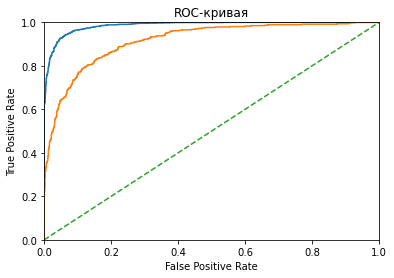

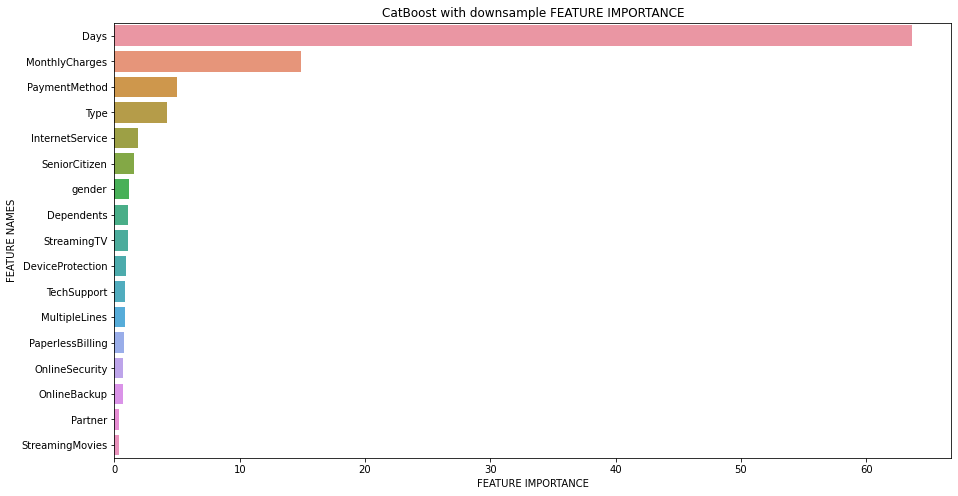

In [16]:
cb_down_data, roc_cb_down_train, roc_cb_down_valid, cb_down_best = gridsearch(cb,param_cb,train_features_down, train_target_down, valid_features, valid_target, 5, scorer)
display(cb_down_data)
roc_auc_plot(roc_cb_down_train,roc_cb_down_valid)
plot_feature_importance(cb_down_best.feature_importances_,train_features.columns,'CatBoost with downsample ')

In [17]:
neural_history,rocauc_train, rocauc_valid = neural_net(train_features, train_target, valid_features, valid_target,150)

ROC-AUC on Neural Net: 0.8281


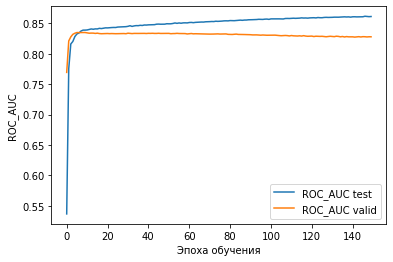

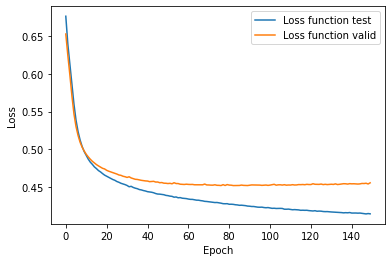

In [18]:
print('ROC-AUC on Neural Net: {:.4f}'.format(rocauc_valid))

plt.plot(neural_history.history['auc'], label='ROC_AUC test')
plt.plot(neural_history.history['val_auc'], label='ROC_AUC valid')
plt.xlabel('Эпоха обучения')
plt.ylabel('ROC_AUC')
plt.legend()
plt.show()

plt.plot(neural_history.history['loss'], label='Loss function test')
plt.plot(neural_history.history['val_loss'], label='Loss function valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
analysis = pd.concat([log_data['values_valid'],forest_data['values_valid'],lgb_data['values_valid'],cb_data['values_valid'],cb_down_data['values_valid']], axis=1, sort=False)
analysis.columns = ['LogisticRegression','Forest','LGBoost','CatBoost','CatBoost w/ ds']
display(analysis)
print()
print('ROC-AUC on Neural Net: {:.4f}'.format(rocauc_valid))

,LogisticRegression,Forest,LGBoost,CatBoost,CatBoost w/ ds
stats,,,,,
accuracy,0.738339,0.754835,0.852673,0.884528,0.857224
roc_auc_proba,0.832476,0.850592,0.903362,0.93106,0.916396
correct_guesses,1298,1327,1499,1555,1507
incorrect_guesses,460,431,259,203,251



ROC-AUC on Neural Net: 0.8281


<div class="alert alert-info">
Conclusion:
    
Overall for business, i would recommend LGBoost.
    
- CatBoost give roc_auc = 0.91, that has enough of recall and precision, but it does rely on 1-2 features way too much (Days), it can cause some problems for business. I would also suggest to do some extra analysis for other data from inside.
- LGBoost give roc_auc = 0.89, it is good enough and it rely on far more features than CatBoost especially on cash features like how much customer has paid and some options like additional services, which business cfn use efficiently. 
- оther algorithms were not goo enough.